# 04. Pytorch Custom Datasets

We've used some datasets with Pytorch before.

But how do you get your own data into Pytorch?

One of the ways to do is via: custom datasets

## Domain libraries

Depending on what you're working on, vision, text, audio, recommendation, you'll want to
look into each of the Pytorch domain libraries for existing data loading functions and
customizable data loading functions.

## 0. Importing PyTorch and setting up device-agnostic code

In [ ]:
import torch
from torch import nn
import torchvision


# Note: Pytorch 2.3.0+cu121 is required for this course
torch.__version__

'2.3.0+cu121'

In [ ]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
!nvidia-smi

Thu Jun 20 12:20:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0              30W /  70W |    245MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 1.Get the data

Our dataset is a subset of the Food101 dataset

Food101 starts with  101 different classes of food and 1000 images per class (750 for training, 250 testing)

Our dataset starts with 3 classes of food and only 10% of the images(~75 training ~25 testing)

Why do this ?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.
The Whole point is to speed up how fast you can experiment

In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

#If the image folder doesn't exist, download it and prepare it......
if image_path.is_dir():
  print(f"{image_path} directory already exists.... skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

#Download pizza, steak and shushi data
with open(data_path / "pizza_steak_shushi.zip","wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, suhsi data...")
  f.write(request.content)

#Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_shushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and shushi data ...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists.... skipping download
Unzipping pizza, steak and shushi data ...


## 2. Becoming one with the data (data prepration and data exploration)

In [ ]:
import os
def walk_through_dir(dir_path):
  """ Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza


In [ ]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualize an image

Let's write some code to:
1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name using 'pathlib.Path.parent.stem`
4. Since we're working with images, let's open with Python's PIL
5. We'll then show the image and print metadata

data/pizza_steak_sushi/train/steak/2561199.jpg
steak
Random image path: data/pizza_steak_sushi/train/steak/2561199.jpg
Image class: steak
Image height: 512
Image width: 512


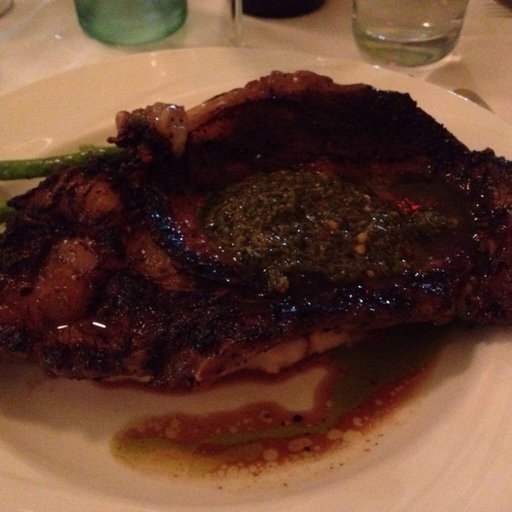

In [ ]:
import random
from PIL import Image

# Set seed
torch.manual_seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img


(-0.5, 511.5, 511.5, -0.5)

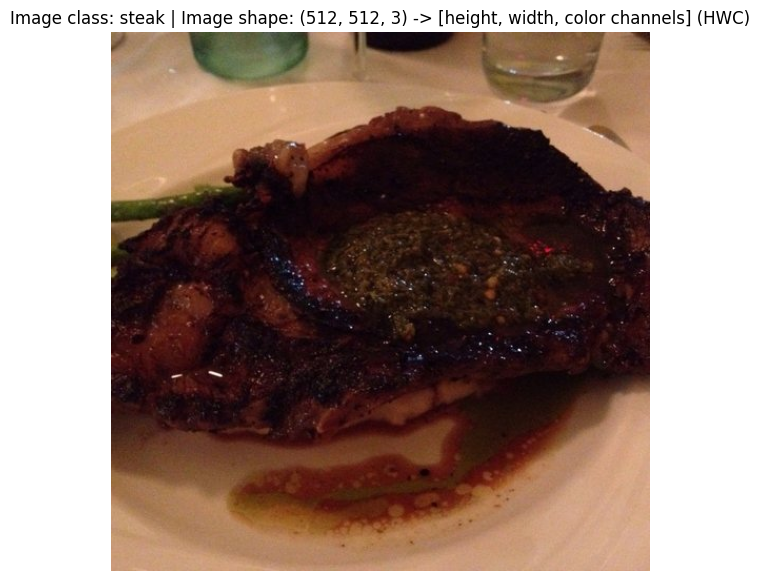

In [ ]:
# Try to visualize with matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Turn the image into an array
img_as_array = np.asarray(img)

#Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color channels] (HWC)")
plt.axis(False)


array([[[151, 124,  81],
        [154, 127,  84],
        [153, 125,  86],
        ...,
        [ 54,  29,  25],
        [ 48,  24,  22],
        [ 64,  40,  38]],

       [[146, 119,  76],
        [147, 119,  79],
        [146, 118,  79],
        ...,
        [ 55,  30,  26],
        [ 48,  22,  21],
        [ 60,  36,  34]],

       [[147, 119,  79],
        [145, 117,  77],
        [143, 115,  76],
        ...,
        [ 51,  26,  21],
        [ 43,  18,  14],
        [ 53,  28,  24]],

       ...,

       [[203, 154, 122],
        [203, 154, 122],
        [202, 153, 121],
        ...,
        [207, 161, 128],
        [207, 161, 127],
        [207, 161, 127]],

       [[204, 155, 123],
        [202, 153, 121],
        [200, 151, 119],
        ...,
        [206, 160, 127],
        [207, 161, 127],
        [208, 162, 126]],

       [[204, 155, 123],
        [201, 152, 120],
        [198, 149, 117],
        ...,
        [207, 161, 127],
        [210, 164, 130],
        [212, 166, 130]]], dtype=uint8)
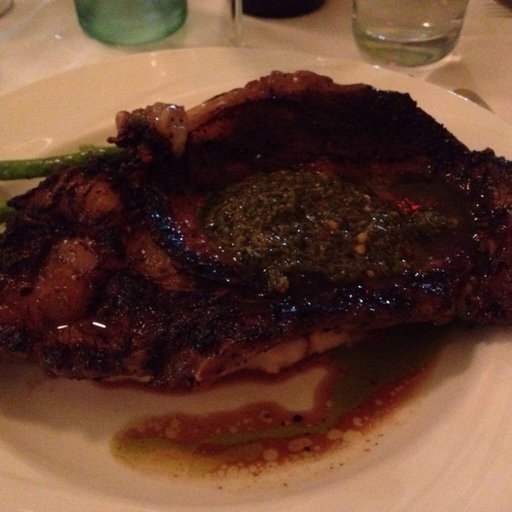

In [ ]:
img_as_array

## 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensor (in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently into a `torch.utils.data.DataLoader`,
we'll call these `Dataset` and `DataLoader`

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import v2

### 3.1 Transforming data with `torchvision.transforms


In [ ]:
# Wrie a transorm for image
data_transform = v2.Compose([
    # convert Pil image to tensor
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    # Resize our image
    v2.Resize(size=(64,64)),
    # Flip the images randomly on the horizontal
    v2.RandomHorizontalFlip(p=0.5),
    # Turn the image into torch.Tensor
]
)

In [ ]:
data_transform(img).shape

torch.Size([3, 64, 64])

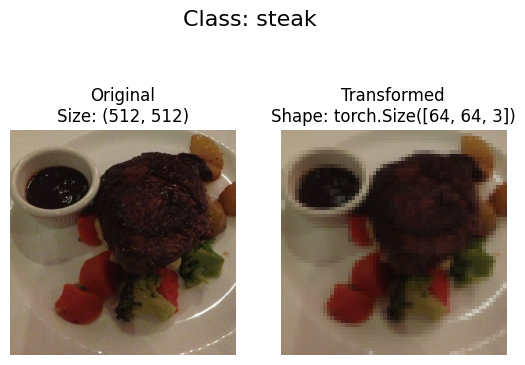

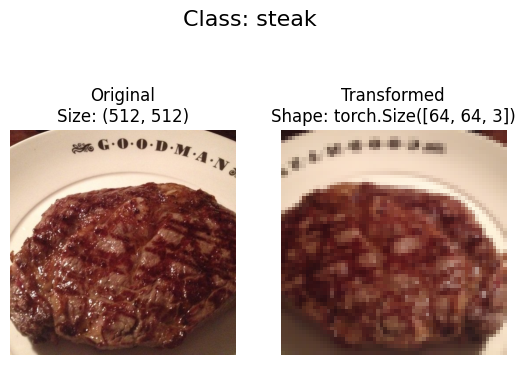

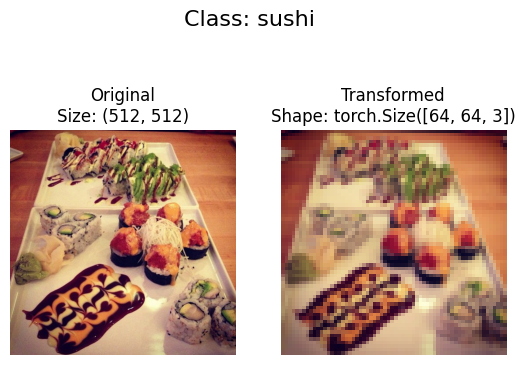

In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  """
  Selects random images from a path of images and loads/transforms
  them then plot the original vs the transformed version
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths,k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1,2,0) # note we will need to change shape for matplotlib (C,H,W) -> (H,W,C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths = image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

## 4. Option 1: Loading image data using ImageFolder

We can load image classification data using `torchvision.datasets.ImageFolder`-


In [ ]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform, # a transform for the data
                                  target_transform = None # a transform for the label/target
                                  )

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform = None)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                  ToImage()
                  ToDtype(scale=True)
                  Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                  RandomHorizontalFlip(p=0.5)
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                  ToImage()
                  ToDtype(scale=True)
                  Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                  RandomHorizontalFlip(p=0.5)
            ))

In [ ]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Check the length of our dataset
len(train_data), len(test_data)

(225, 75)

In [ ]:
# Index on the train_data Dataset to get a single image and it's label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f" Lable datatype: {type(label)}")

Image tensor:
 Image([[[0.1123, 0.1035, 0.0997,  ..., 0.1241, 0.1200, 0.1193],
        [0.1042, 0.0958, 0.0969,  ..., 0.1291, 0.1303, 0.1303],
        [0.1022, 0.0965, 0.0960,  ..., 0.1348, 0.1342, 0.1338],
        ...,
        [0.1088, 0.1095, 0.1236,  ..., 0.1687, 0.1636, 0.1688],
        [0.0889, 0.0953, 0.1105,  ..., 0.1688, 0.1653, 0.1699],
        [0.0861, 0.0875, 0.0990,  ..., 0.1692, 0.1647, 0.1665]],

       [[0.0725, 0.0722, 0.0755,  ..., 0.0596, 0.0604, 0.0607],
        [0.0726, 0.0723, 0.0733,  ..., 0.0639, 0.0639, 0.0639],
        [0.0710, 0.0741, 0.0724,  ..., 0.0717, 0.0705, 0.0700],
        ...,
        [0.1238, 0.1322, 0.1393,  ..., 0.2505, 0.2405, 0.2373],
        [0.1108, 0.1170, 0.1258,  ..., 0.2517, 0.2377, 0.2326],
        [0.1029, 0.1038, 0.1147,  ..., 0.2443, 0.2354, 0.2283]],

       [[0.0944, 0.0906, 0.0914,  ..., 0.0171, 0.0214, 0.0218],
        [0.0911, 0.0885, 0.0900,  ..., 0.0184, 0.0174, 0.0175],
        [0.0893, 0.0900, 0.0889,  ..., 0.0147, 0.0141, 0.01

In [ ]:
label

0

In [ ]:
class_names[label]

'pizza'

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

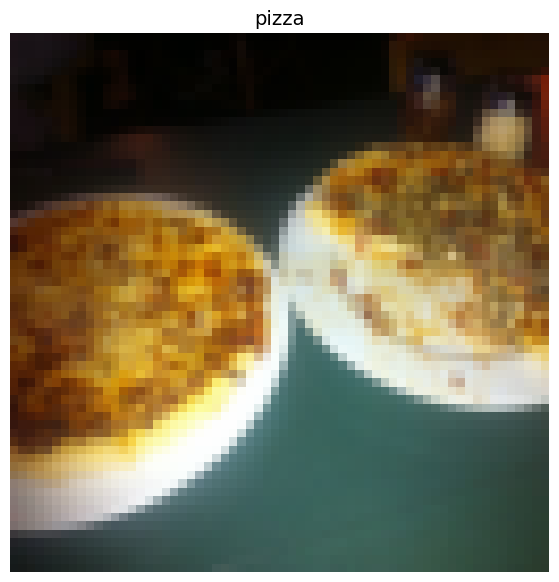

In [ ]:
# Rearrange the order dimension
img_permute = img.permute(1,2,0)

#Print out different Shape
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

#Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=14)

## 4.1 Turn loaded images into `DataLoader's`

A `DatalLoader` is going to help us turn our `Dataset`'s into iterables and we can customise the `batch_size` so our model can see `batch_size` image at a time

In [ ]:
import os
os.cpu_count()

2

In [ ]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
import os

BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers = os.cpu_count(),
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size =BATCH_SIZE,
                             num_workers = os.cpu_count(),
                             shuffle = False)


train_dataloader, test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x7c7439434ee0>,
 <torch.utils.data.dataloader.DataLoader at 0x7c7439435270>)

In [ ]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [ ]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if you like
print(f"Image shape: {img.shape} -> [batch_size, color_channels,height,width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels,height,width]
Label shape: torch.Size([1])


## 5 Option 2: Loading Image Data with Custom `Dataset`

1. Want to be able to load image from file
2. Want to be able to get class name from Datset
3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not Limited to Pytorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it doesn't mean it will work...
* Using a custom `Datset` often results in us writing more code, which could be prone to errors or
performance issue



All custom dataset in PyTorch, often subclass- `torch.utils.data.Dataset`

In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms import v2
from typing import Tuple, Dict, List

In [ ]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally
the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with directory structure).
3. Turn the class names into a dict and a list and return them.

In [ ]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [ ]:
list(os.scandir(target_directory))

[<DirEntry 'steak'>, <DirEntry 'sushi'>, <DirEntry 'pizza'>]

In [ ]:
def find_classes(directory:str)->Tuple[List[str],Dict[str,int]]:
  """Finds the class folder names in target directory"""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")

  # 3. Create a directory of index labels (computers prefer numbes rather than strings as labels)
  class_to_idx = {class_name: i for i , class_name in enumerate(classes)}
  return classes, class_to_idx

In [ ]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

 ### 5.2 Create a custom `Dataset` to replicate ImageFolder

 To create our own custom datset, we want to:

 1. Subclass `torch.utils.data.Datset`
 2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
 3. Create several attributes
  * paths - paths of our image
  * transform - the transform we'd like to use
  * classes - a list of the target classes
  * class_to_idx - a dict of the target classes mapped to integer labels

  4. Create a function to `load_images()`, this function will open an image
  5. Overwrite the `__len()__` method to return the length of our dataset
  6. Overwrite the `__getitem()__` method to return a given sample when passed an index
  


In [ ]:
# Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self, targ_dir: str,
               transform=None):
    # 3. Create class attributes
    # Get all of the image Path
    self.path = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Setup transforms
    self.transform = transform
    # Create classes and class_to_idx
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self, index:int) -> Image.Image:
    "Opens an image via a path and return it"
    image_path = self.path[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    "Returns the total number of samples"
    return len(self.path)

  # 6. OVerwrite __getitem__() method to return a particular sample
  def __getitem__(self, index) -> Tuple[torch.Tensor,int]:
    "Returns one sample of data, data and label (X,y)"
    img = self.load_image(index)
    class_name = self.path[index].parent.name #expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transfomr if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label (X,y)
    else:
      return img, class_idx # return untransformed image and label

In [ ]:
# Create a transform
from torchvision.transforms import v2

train_transforms = v2.Compose([
    v2.Resize(size=(64,64)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToImage(),
    v2.ToDtype(dtype=torch.float, scale= True),
])

test_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(dtype=torch.float, scale=True),
    v2.Resize(size=(64,64))
])

In [ ]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir = train_dir,
                                      transform = train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transform)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7c74394cd570>,
 <__main__.ImageFolderCustom at 0x7c74394cd2a0>)

In [ ]:
len(train_data), len(train_data_custom)

(225, 225)

In [ ]:
len(test_data), len(test_data_custom)

(75, 75)

In [ ]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [ ]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustomDataset
print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many
images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target dataset
5. Setup a matplotlib plot
6. Loop through the random sample images indexes and plot them with plt.matplotlib
7. Make sure the dimensions of our images line up with matplotlib (HWC)


In [ ]:
# 1. Create a function to take in a datset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is too high
  if n>10:
    n= 10
    display_shape = False
    print(f"For display, purpose, n shouldn't be larger than 10, setting to 10 and removing shape display.")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)),k=n)

  # 5. Setup plot
  plt.figure(figsize=(16,8))

  # 6. Loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7.  Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1,2,0) # [color_channels, height, width] -> [height, width, color_channels]

    # Plot adjusted sample
    plt.subplot(1,n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis(False)
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)

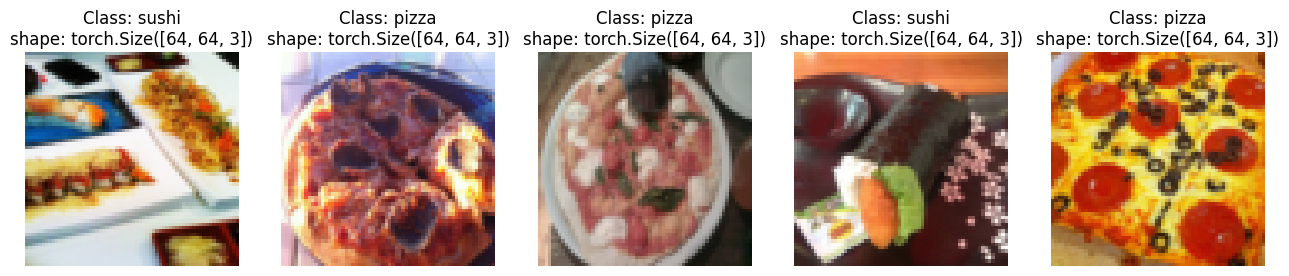

In [ ]:
# Display random images form the ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes = class_names,
                      seed = 42)

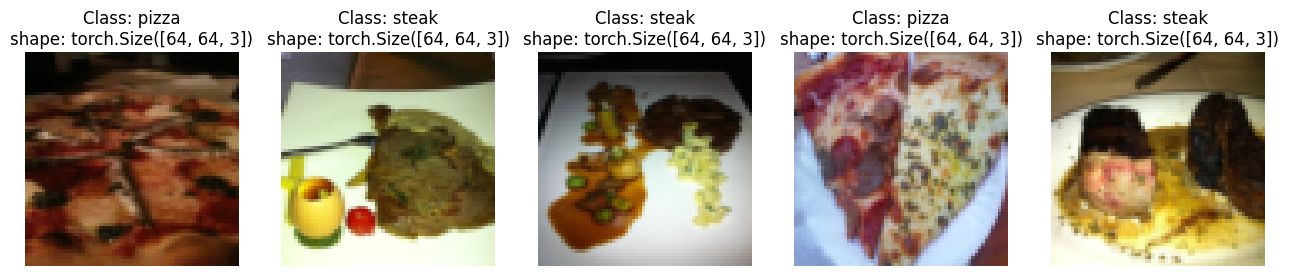

In [ ]:
# Display random images form the Custome ImageFolder created Dataset
display_random_images(train_data_custom,
                      n=5,
                      classes = class_names,
                      seed = 42)

### 5.4 Turn custom loaded images into `DataLoader`'s

In [ ]:
from torch.utils.data import DataLoader
import os

BATCH_SIZE = 32 # a good batch size is multiple of 8
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset= train_data_custom,
                                     batch_size = BATCH_SIZE,
                                     num_workers=NUM_WORKERS ,
                                     shuffle = True)

test_dataloader_custom = DataLoader(dataset = test_data_custom,
                                    batch_size = BATCH_SIZE,
                                    num_workers = NUM_WORKERS ,
                                    shuffle= False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7c74ac4d6110>,
 <torch.utils.data.dataloader.DataLoader at 0x7c74394a7310>)

In [ ]:
#Get image and label form custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shape
img_custom.shape, label_custom.shape


(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transforms (data augmentation)

Data augmentation is the process of articially adding diversity to your training data.

In the case of image data, this may mean applying various image transformations to the training images

This practice hopefully results in a model that's more generalizable to unseen data.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art level........


*Note: There are many more different kinds of data augmentation such as cropping, replacing, shearing, Rotate, Shift(axis), Zoom, etc

In [ ]:
# Let's look at trivialaugment   - https://medium.com/geekculture/trivialaugment-the-next-evolution-in-data-augmentation-a218339a2687
from torchvision.transforms import v2
import torch

train_transform = v2.Compose([
    v2.Resize(size=(224,224)),
    v2.TrivialAugmentWide(num_magnitude_bins=31),
    v2.ToImage(),
    v2.ToDtype(dtype=torch.float, scale=True)
])


test_transform = v2.Compose([
    v2.Resize(size =(224,224)),
    v2.ToImage(),
    v2.ToDtype(dtype = torch.float, scale=True)
])


In [ ]:
image_path

PosixPath('data/pizza_steak_sushi')

In [ ]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/steak/2707522.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2648423.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1257104.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/339891.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/3577618.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/3142045.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/167069.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/3074367.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2087958.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2129685.jpg')]

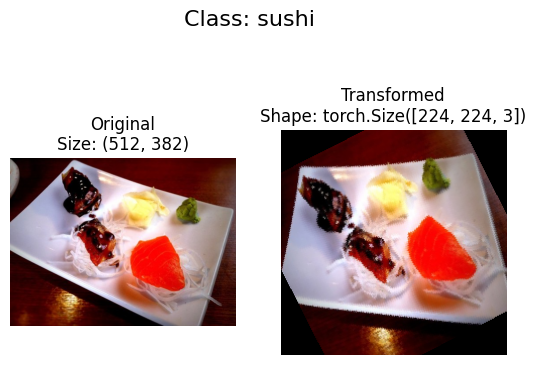

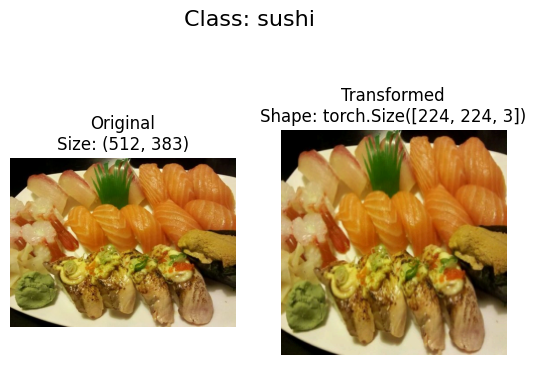

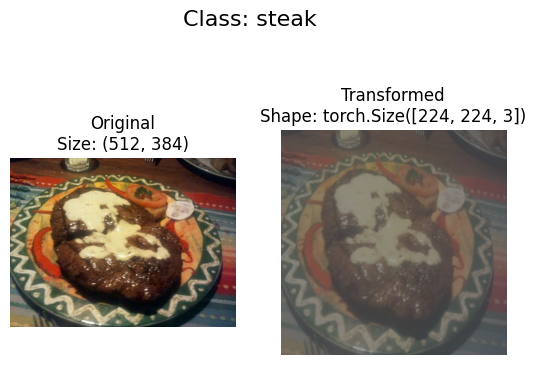

In [ ]:
# Plot random transform images
plot_transformed_images(
    image_paths = image_path_list,
    transform = train_transform,
    n=3,
    seed = None

)

## 7. Model 0: TinyVGG without data augmentation


Let's replicate TinyVGG architecture from the CNN Explainer

### 7.1 Creating transform and loading data for Model 0

In [ ]:
# Create  simple transform

simple_transform = v2.Compose([
    v2.Resize(size=(64,64)),
    v2.ToImage(),
    v2.ToDtype(dtype=torch.float, scale=True),
])

In [ ]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root= train_dir,
                                        transform = simple_transform)

test_data_simple = datasets.ImageFolder(root = test_dir,
                                       transform = simple_transform)

# 2. Turns the data set into Data loader
import os
from torch.utils.data import DataLoader


# Setup batch size and number of works
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create dataLoader's
train_dataloader_simple = DataLoader(dataset = train_data_simple,
                                     batch_size = BATCH_SIZE,
                                     shuffle=True,
                                     num_workers = NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset = test_data_simple,
                                    batch_size = BATCH_SIZE,
                                    shuffle = False,
                                    num_workers = NUM_WORKERS
                                    )

In [ ]:
NUM_WORKERS

2

### 7.2 Create TinyVGG model class

In [ ]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explainer
  """
  def __init__(self,input_shape:int,
               hidden_units:int,
               output_shape:int) -> None:

    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride=1,
                  padding =0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                      stride = 2)  # default stride value is same as kernel_size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding =0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels=hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding =0 ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
                      stride = 2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*13*13,
                  out_features = output_shape)
    )


  def forward(self,x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x


In [ ]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels in our image data
                  hidden_units = 10,
                  output_shape = len(class_names)
                  ).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)


In [ ]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape , label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
# Try a forward pass
temp_pred = model_0(image_batch.to(device))
torch.argmax(torch.softmax(temp_pred,dim=1),dim=1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [ ]:
# install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0,input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

## 7.5 Create train and test loops functions

* `train_step()` - takes in a model and dataloader and trains the model on the dataloader
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader

In [ ]:
# Create train_step()
def train_step(model:torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device = device):

  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  #Loop through data loader data batches
  for batch, (X,y) in enumerate(dataloader):
    X,y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc

In [ ]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device = device):
  # put model in eval mode
  model.eval()

  #Setup test loss and test accuracy values
  test_loss , test_acc = 0, 0

  #Turn on inference mode
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X,y) in enumerate(dataloader):
      # Send data to the target device
      X,y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits,y)
      test_loss += loss.item()

      # Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += (test_pred_labels == y).sum().item() /len(test_pred_labels)

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()

In [ ]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloader + loss function
def train(model:torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device = device):

  # 2. Create empty results dictionary
  results = {"train_loss":[],
             "train_accuracy":[],
             "test_loss":[],
             "test_acc":[]}

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model= model,
                                       dataloader = train_dataloader,
                                       loss_fn = loss_fn,
                                       optimizer = optimizer,
                                       device = device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader = test_dataloader,
                                    loss_fn = loss_fn,
                                    device = device)

    # 4. print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_accuracy"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)


  # 6. Return the filled results at the end of the epochs
  return results

### 7.7 Train and evaluate model 0


In [ ]:
# set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)


# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape = 3, # number of color channels of our target images
                  hidden_units = 10,
                  output_shape = len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader = train_dataloader_simple,
                        test_dataloader = test_dataloader_simple,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS,

                        )

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1063 | Train acc: 0.3047 | Test loss: 1.0983 | Test acc: 0.3011
Epoch: 1 | Train loss: 1.0998 | Train acc: 0.3281 | Test loss: 1.0697 | Test acc: 0.5417
Epoch: 2 | Train loss: 1.0869 | Train acc: 0.4883 | Test loss: 1.0809 | Test acc: 0.4924
Epoch: 3 | Train loss: 1.0845 | Train acc: 0.3984 | Test loss: 1.0606 | Test acc: 0.5833
Epoch: 4 | Train loss: 1.0661 | Train acc: 0.4219 | Test loss: 1.0655 | Test acc: 0.5644
Total training time: 8.236 seconds


### 7.8 Plot the loss curve of Model 0

A **Loss Curve** is a way of tracking your model's progress over time



In [ ]:
# Get the model_0_results key
model_0_results.keys()

dict_keys(['train_loss', 'train_accuracy', 'test_loss', 'test_acc'])

In [ ]:
def plot_loss_curve(results: Dict[str, List[float]]):
  """ Plot training curve of a results dictionary"""
  # Get the loss values of results dictionary(training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results["train_accuracy"]
  test_accuracy = results["test_acc"]

  # Figure out how many epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15,7))

  # Plot the loss
  plt.subplot(1,2,1)
  plt.plot(epochs,loss,label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  #Plot the accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

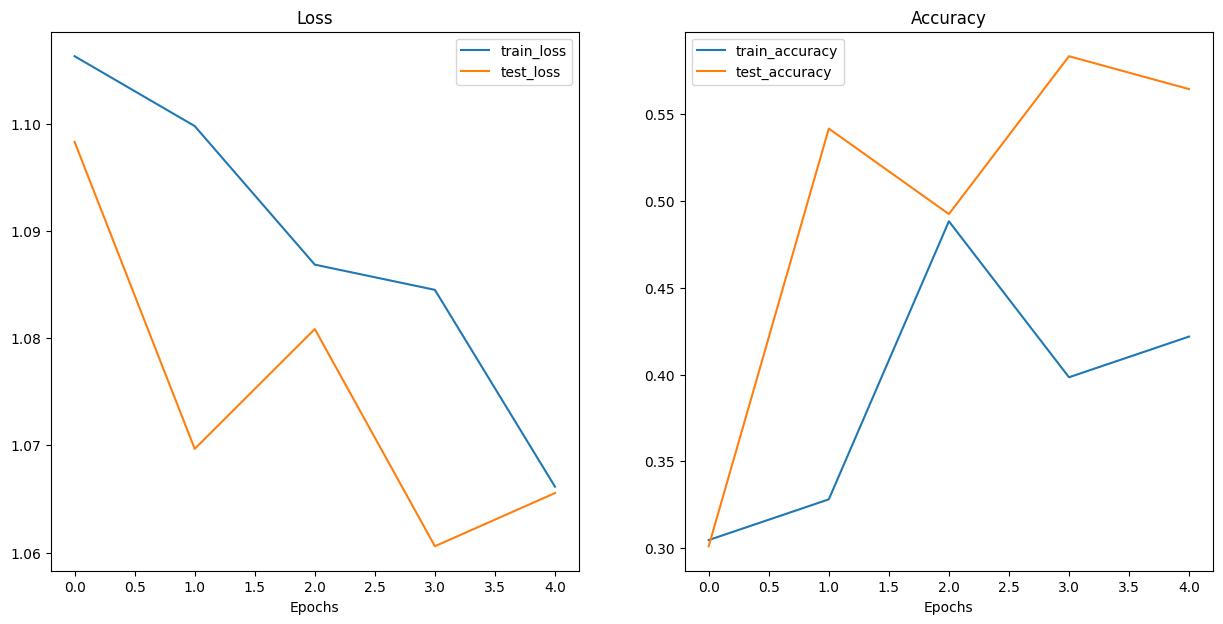

In [ ]:
plot_loss_curve(model_0_results)

### 8. What should an ideal loss curve look like?

A loss curve is one of the most helpful ways to troubleshoot a model.

## 9.1 Model 1: TinyVGG with data agumentation

Now let's try another modelling experiment this time using the same model as before with some data augmentation

In [ ]:
# Create training transform with TrivialAugment
from torchvision.transforms import v2
train_transform_trivial = v2.Compose([
    v2.TrivialAugmentWide(num_magnitude_bins=31),
    v2.Resize(size=(64,64)),
    v2.ToImage(),
    v2.ToDtype(dtype= torch.float, scale = True)
])

test_transform_trivial = v2.Compose([
    v2.Resize(size = (64,64)),
    v2.ToImage(),
    v2.ToDtype(dtype=torch.float, scale= True)
])


### 9.2 Create train and test Dataset's and DataLoader's With data agumentation

In [ ]:
# Turn image folders into Datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root = train_dir,
                                            transform = train_transform_trivial,
                                            target_transform = None,
)

test_data_simple = datasets.ImageFolder(root = test_dir,
                                        transform = simple_transform,
                                        target_transform = None)



In [ ]:
# Turn our Datasets into DataLoaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset= train_data_augmented,
                                        batch_size = BATCH_SIZE,
                                        shuffle = True,
                                        num_workers = NUM_WORKERS,
                                        )

test_dataloader_simple = DataLoader(dataset = test_data_simple,
                                    batch_size = BATCH_SIZE,
                                    shuffle = False,
                                    num_workers = NUM_WORKERS)

### 9.3 Construct and train model 1

This time we'll be using the same model architecture except this time we've augmented the traning data



In [ ]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units =10,
                  output_shape = len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

Woderful ! Now we've a model and dataloaders, let's create a loss function and an optimizer and call upon `train()` function to train and evaluate our model.

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 5

# Setup loss/criterion funciton
loss_fn = nn.CrossEntropyLoss()
optimizer  = torch.optim.Adam(params = model_1.parameters(),
                              lr =0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

#Train model 1
model_1_results = train(model= model_1,
                        train_dataloader = train_dataloader_augmented,
                        test_dataloader = test_dataloader_simple,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS,
                        device = device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time for model_1: {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1047 | Train acc: 0.2500 | Test loss: 1.1010 | Test acc: 0.2604
Epoch: 1 | Train loss: 1.0800 | Train acc: 0.4258 | Test loss: 1.1267 | Test acc: 0.2604
Epoch: 2 | Train loss: 1.0807 | Train acc: 0.4258 | Test loss: 1.1583 | Test acc: 0.2604
Epoch: 3 | Train loss: 1.1206 | Train acc: 0.3047 | Test loss: 1.1577 | Test acc: 0.2604
Epoch: 4 | Train loss: 1.0866 | Train acc: 0.4297 | Test loss: 1.1594 | Test acc: 0.3333
Total training time for model_1: 7.756 seconds


### 9.4 Plot the loss curves of model 1
A loss curve helps you evaluate your models performance overtime

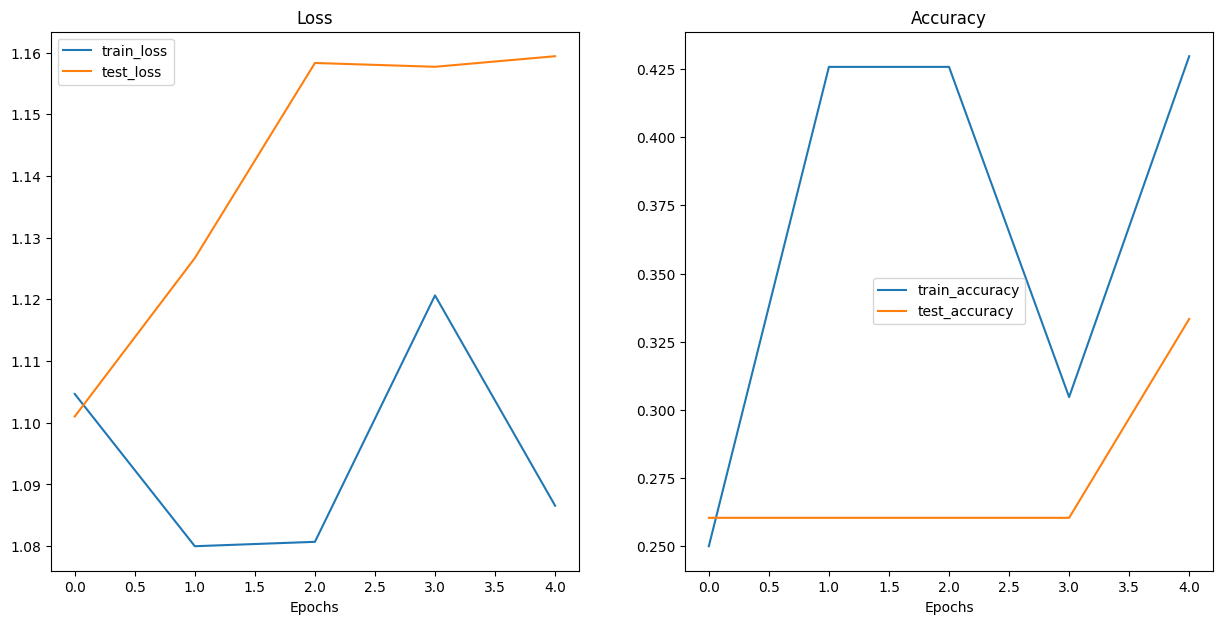

In [ ]:
plot_loss_curve(model_1_results)

## 10. Compare model results

After evaluating our modelling experiments on their own, it's important to compare them to each other.

There's a few different ways to do this:
1. Hard coding (what we're doing)
2. PyTorch + Tensorboard - https://pytorch.org/docs/stable/tensorboard.html
3. Weight & Biase
4. MLFLOW - https://mlflow.org/
                

In [ ]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_1_df

,train_loss,train_accuracy,test_loss,test_acc
0,1.104668,0.250000,1.101022,0.260417
1,1.079996,0.425781,1.126686,0.260417
2,1.080708,0.425781,1.158303,0.260417
3,1.120639,0.304688,1.157688,0.260417
4,1.086562,0.429688,1.159398,0.333333


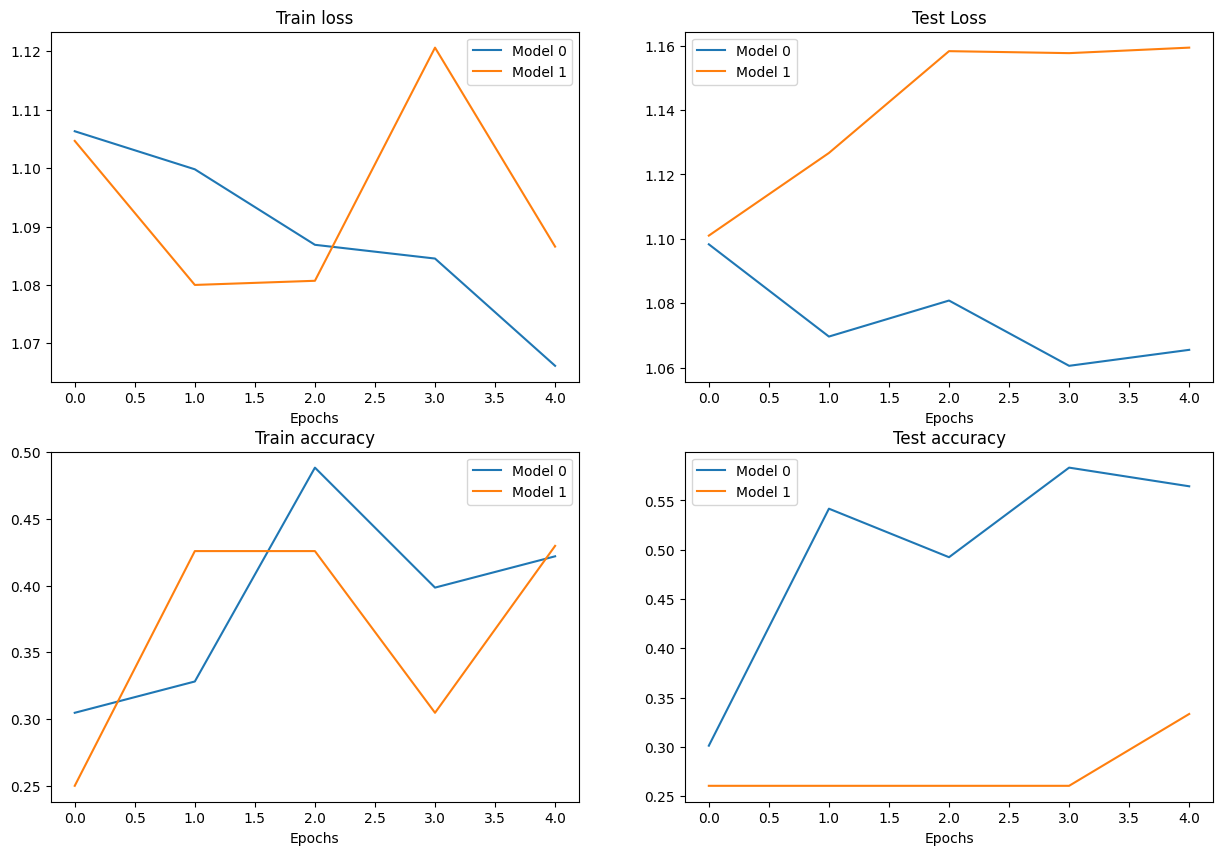

In [ ]:
# Setup a plot
plt.figure(figsize=(15,10))

# Get number of epochs
epochs = range(len(model_0_df))

# plot train loss
plt.subplot(2,2,1)
plt.plot(epochs, model_0_df["train_loss"],label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label = "Model 1")
plt.title("Train loss")
plt.xlabel("Epochs")
plt.legend()


# plot test loss
plt.subplot(2,2,2)
plt.plot(epochs, model_0_df["test_loss"],label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label = "Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()


# plot train accuracy
plt.subplot(2,2,3)
plt.plot(epochs, model_0_df["train_accuracy"],label="Model 0")
plt.plot(epochs, model_1_df["train_accuracy"], label = "Model 1")
plt.title("Train accuracy")
plt.xlabel("Epochs")
plt.legend()


# plot test accuracy
plt.subplot(2,2,4)
plt.plot(epochs, model_0_df["test_acc"],label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label = "Model 1")
plt.title("Test accuracy")
plt.xlabel("Epochs")
plt.legend()




## 11. Making a prediction on a custom image

Although we've trained a model on custom data... how do you make a prediction on a sample/image
that's not in either training or testing dataset.

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path  = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path,"wb") as f:
    # when downloading from GitHub, need to use the "raw" file link
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}....")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download.....")

### 11.1 Loading in a custom image with Pytorch

We have to make sure our custom image is in the same format as the data our model was trained on

* In tensor form with datatype(torch.float32)
* Of Shape 3*64*64
* On the right device

We can read an image into PyTorch using -
https://pytorch.org/vision/main/generated/torchvision.io.read_image.html

In [ ]:
import torchvision

#Read in custom image  it by default read in unit8 format
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

print(f"Custom image tensor:\n {custom_image_uint8}")
print(f"Custom image shape:\n {custom_image_uint8.shape}")
print(f"Custom image dtype:\n {custom_image_uint8.dtype}")

Custom image tensor:
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape:
 torch.Size([3, 4032, 3024])
Custom image dty

### 11.2 Making a prediction on a custom image with trained Pytorch model


In [ ]:
# Try to make a prediction on an image in uint8 format
model_1.eval()
with torch.inference_mode():
  model_1(custom_image_uint8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [ ]:
# Loading in the custom image and convert to torch.float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) /255

custom_image.dtype

torch.float32

In [ ]:
# Try to make a prediction on an image in uint8 format
model_1.eval()
with torch.inference_mode():
  model_1(custom_image.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x756765 and 1690x3)

In [ ]:
# Create transform pipeline to resize image
from torchvision.transforms import v2

custom_image_transform = v2.Compose([
    v2.Resize(size=(64,64))
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

#Print out the shape
print(f"Origina shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")

Origina shape: torch.Size([3, 4032, 3024])
Transformed shape: torch.Size([3, 64, 64])


In [ ]:
# THis will error no batch size
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x169 and 1690x3)

In [ ]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))

custom_image_pred

tensor([[ 0.0740,  0.0489, -0.2236]], device='cuda:0')

Note, to make a prediction on a custom image we had to:
* Load the image and turns it into a tensor
* Make sure the image was the same datatype as the model (torch.float32)
* Make sure the image was the same shape as the data the model was trained on (3,64,64) with a batch size ... (1,3,64,64)
* Make sure the image was on the same device as our mode

In [ ]:
# Convert logits -> prediction probabilites
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.3679, 0.3588, 0.2732]], device='cuda:0')

In [ ]:
# Convert prediction probabilites -> prediction labels
custom_image_pred_labels = torch.argmax(custom_image_pred_probs,dim=1).cpu()
custom_image_pred_labels.item()

0

In [ ]:
class_names[custom_image_pred_labels.item()]

'pizza'

### 11.3 Putting custom image prediction together: building function
ideal outcome:
A function where we pass an image path to and have our model predict on that image and plot the image + prediction

In [ ]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str]= None,
                        transform = None,
                        device = device):
  """Make a prediction on a target image with a trained model and plots the image and prediction."""
  # Load in the image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # Divide the image pixel values by 255 to get them between [0,1]
  target_image = target_image / 255.

  # Transform if necessary
  if transform:
    target_image = transform(target_image)

  #Make sure the model is on the target device
  model.to(device)

  #Turn on eval/inference mode and make a predcition
  model.eval()
  with torch.inference_mode():
    # Add extra dimension to the image (this is the batch dimension, e.g our model will predict on batches of 1x image)
    target_image = target_image.unsqueeze(0)

    # Make a prediction on the image with an extra dimension
    target_image_pred = model(target_image.to(device)) #make sure the image is on the right device

  # Convert logits -> prediction probabilities
  target_image_pred_probs = torch.softmax(target_image_pred,dim=1)

  # Convert prediction probabilites -> prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # Plot the image alongside the prediction and prediction probabilities
  plt.imshow(target_image.squeeze().permute(1,2,0)) # remove batch dimesnion and rearrange shape to HWC

  if class_names:
    title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  else:
    title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"

  plt.title(title)
  plt.axis(False)


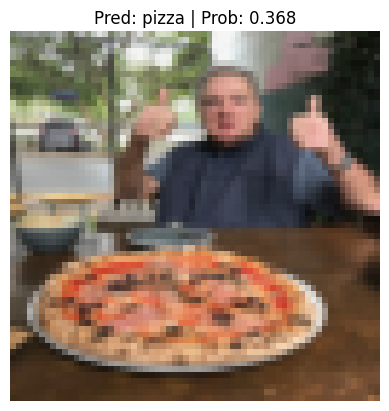

In [ ]:
# Pred on our custom image
pred_and_plot_image(model= model_1,
                    image_path = custom_image_path,
                    class_names = class_names,
                    transform = custom_image_transform,
                    device = device)